In [1]:
from MetricLearning.src.metric_learning_adjacent.build_graphs import *
from tqdm import tqdm

In [3]:
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

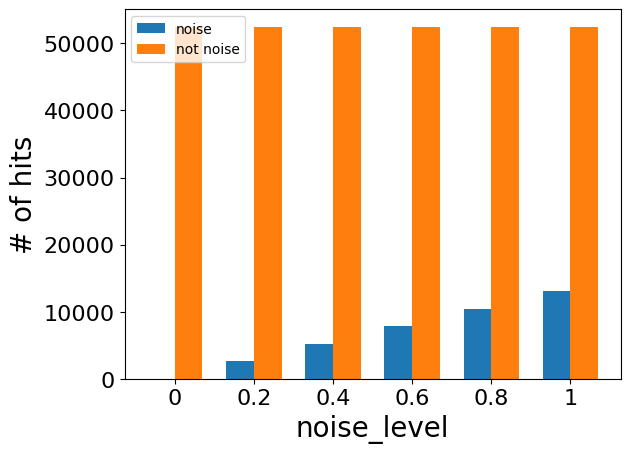

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['default', '/global/homes/a/aoka/style.mplstyle'])

noise_hits = []
not_noise_hits = []
noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    n_noise = sum(truth['particle_id']==0)
    noise_hits.append(n_noise)
    not_noise_hits.append(len(truth)-n_noise)

x = np.arange(len(noise_keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noise_hits, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise_hits, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('noise_level')
ax.set_xticks(x)
ax.set_xticklabels(noise_keeps)
ax.legend()

# Embedding

In [5]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
    
    emb_neighbors = emb_neighbors[index]
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [6]:
def get_emb_eff_purity(hits, truth, emb_neighbors):
    n_iter = len(hits)
    purity = []
    efficiency = []

    for i in tqdm(range(n_iter)):
        p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors)
        if p: purity.append(p)
        if eff: efficiency.append(eff)

    return purity, efficiency

# Filtering

In [67]:
def get_filter_eff_purity(hits, truth, neighbors, threshold=0.95):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get true pairs
    true_pairs = []
    truth_np = np.array(truth.values)
    
    with torch.autograd.no_grad():
        for i, pair in tqdm(enumerate(idx_pairs)):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
                
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, threshold)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Overall purity and efficiency

In [64]:
def get_overall_eff_purity(hits, truth, neighbors, threshold=0.95):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get true pairs from original dataset
    true_pairs = []
    for pid in tqdm(truth['particle_id'].unique()):
        if pid == 0: continue
        seed_hits = hits[truth['particle_id']==pid].index.values.astype(int)
        for i in seed_hits:
            hit = hits.iloc[i]
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], seed_hits, vol[0], vol[1])
            true_pairs += [(i, n) for n in true_neighbors]
                
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, threshold)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Plotting

In [10]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_with_noise"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [08:59<00:00, 97.28it/s] 


emb result: 0.007660835993598502 0.8938439921059295
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


10659558it [00:22, 476722.96it/s]


filter result: 0.08037066346632163 0.970080634474041
    0% of doublets filtered
   20% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8187/8187 [00:27<00:00, 302.36it/s]


overall result: 0.08036981889954638 0.9410700158227848
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [09:08<00:00, 100.40it/s]


emb result: 0.0072943700197782785 0.8938439921059295
    0% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


11653832it [00:23, 502811.59it/s]


filter result: 0.0741656924635648 0.970080634474041
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:29<00:00, 277.25it/s]


overall result: 0.07416491310108331 0.9410700158227848
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [09:21<00:00, 102.78it/s]


emb result: 0.00696873364741881 0.8938439921059295
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


12768900it [00:23, 534663.78it/s]


filter result: 0.068357711056103 0.9700608568894687
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:30<00:00, 267.41it/s]


overall result: 0.06835699272619132 0.9410700158227848
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [09:40<00:00, 103.84it/s]


emb result: 0.006673427902650945 0.8938439921059295
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


13959788it [00:30, 461896.19it/s]


filter result: 0.06297119042561569 0.9700608568894687
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:28<00:00, 288.93it/s]


overall result: 0.06297052869939697 0.9410700158227848
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [09:53<00:00, 105.99it/s]


emb result: 0.006409880162630224 0.8938439921059295
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


15197721it [00:28, 534746.21it/s]


filter result: 0.05815749250892726 0.970090523568749
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered


100%|██████████| 8188/8188 [00:29<00:00, 276.07it/s]


overall result: 0.058156881366953475 0.9410700158227848
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [10:11<00:00, 107.19it/s]


emb result: 0.00615924073473486 0.8938439921059295
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


16585200it [00:31, 533207.28it/s]


filter result: 0.053456482136326894 0.9700707455809496
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:29<00:00, 276.24it/s]


overall result: 0.05345592039443269 0.9410700158227848


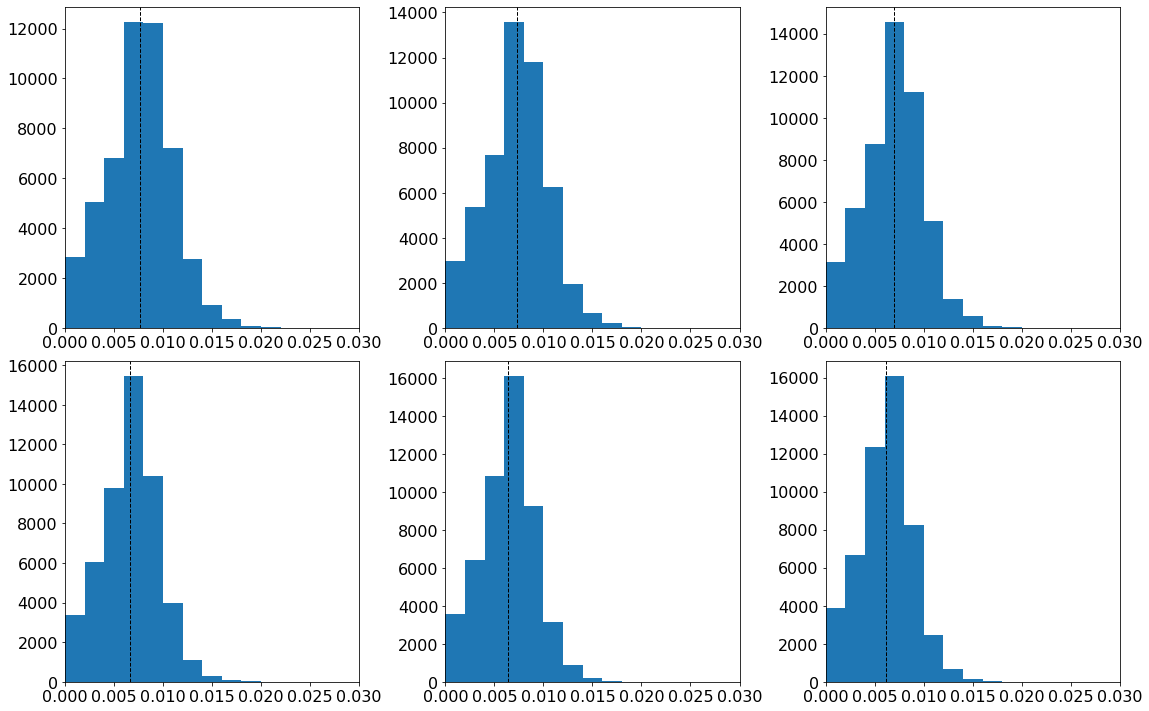

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
emb_ps = []
emb_efs = []
filter_ps = []
filter_efs = []
overall_ps = []
overall_efs = []

fig, axes = plt.subplots(2, 3, figsize=(16,10))

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors)
    axes[i//3][i%3].hist(emb_purity, 50, range=(0, 0.1))
    emb_purity = sum(emb_purity)/len(emb_purity)
    emb_efficiency = sum(emb_efficiency)/len(emb_efficiency)
    print("emb result:", emb_purity, emb_efficiency)
    axes[i//3][i%3].axvline(emb_purity, color='k', linestyle='dashed', linewidth=1)
    axes[i//3][i%3].set_xlim(0, 0.03)
    emb_ps.append(emb_purity)
    emb_efs.append(emb_efficiency)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, neighbors)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
    overall_purity, overall_efficiency = get_overall_eff_purity(hits, truth, neighbors)
    print("overall result:", overall_purity, overall_efficiency)
    overall_ps.append(overall_purity)
    overall_efs.append(overall_efficiency)
    
plt.tight_layout()

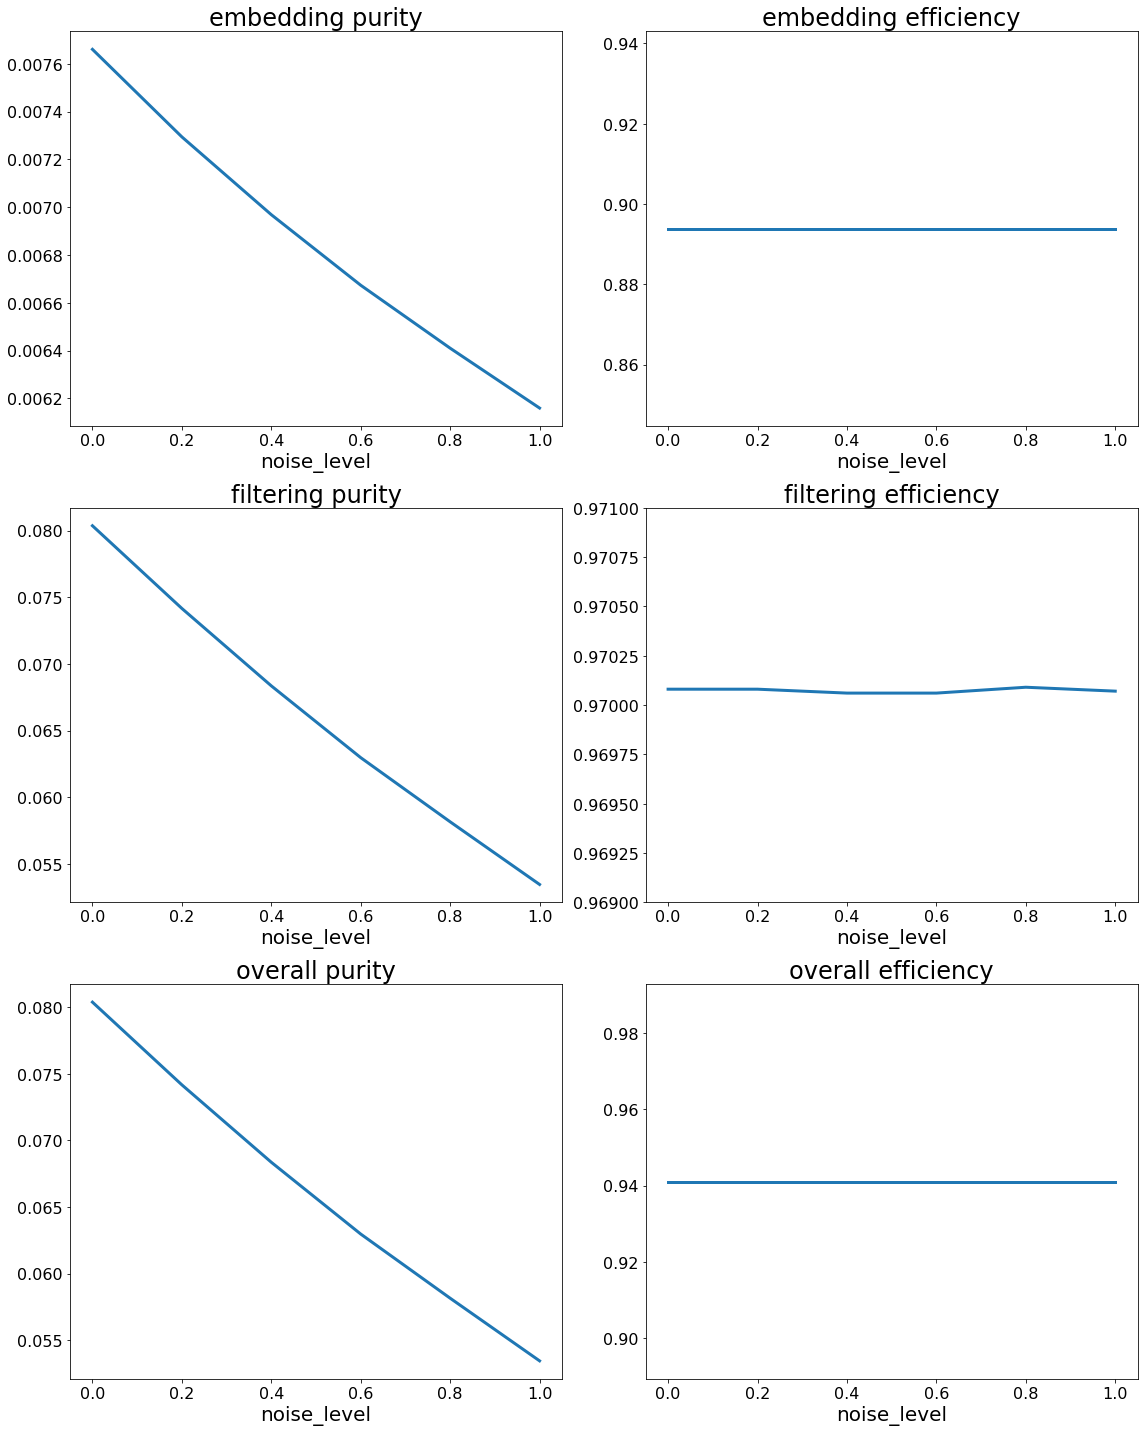

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,20))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, emb_ps)
ax1.set_title("embedding purity")
ax1.set_xlabel("noise_level")
ax2.plot(x, emb_efs)
ax2.set_title("embedding efficiency")
ax2.set_xlabel("noise_level")

ax3.plot(x, filter_ps)
ax3.set_title("filtering purity")
ax3.set_xlabel("noise_level")
ax4.plot(x, filter_efs)
ax4.set_ylim(0.969, 0.971)
ax4.set_title("filtering efficiency")
ax4.set_xlabel("noise_level")

ax5.plot(x, overall_ps)
ax5.set_title("overall purity")
ax5.set_xlabel("noise_level")
ax6.plot(x, overall_efs)
ax6.set_title("overall efficiency")
ax6.set_xlabel("noise_level")

plt.tight_layout()

# Noise hits in embedding neighbors

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [00:42<00:00, 1246.22it/s]


result: 0.0 0.0 0.01815660920041634
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [00:49<00:00, 1120.76it/s]


result: 51.215504410643625 0.0196077735109659 0.018282436384850442
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [00:54<00:00, 1055.68it/s]


result: 103.38988543995563 0.01981788105040383 0.018415909151050205
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [00:59<00:00, 1006.95it/s]


result: 156.6267864840667 0.019998312881009207 0.018548997477249873
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [01:06<00:00, 950.50it/s] 


result: 208.0156222657058 0.020045834274424575 0.018648778139599437
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [01:13<00:00, 894.85it/s] 


result: 263.1306663817577 0.020184923778900965 0.01877026318695632


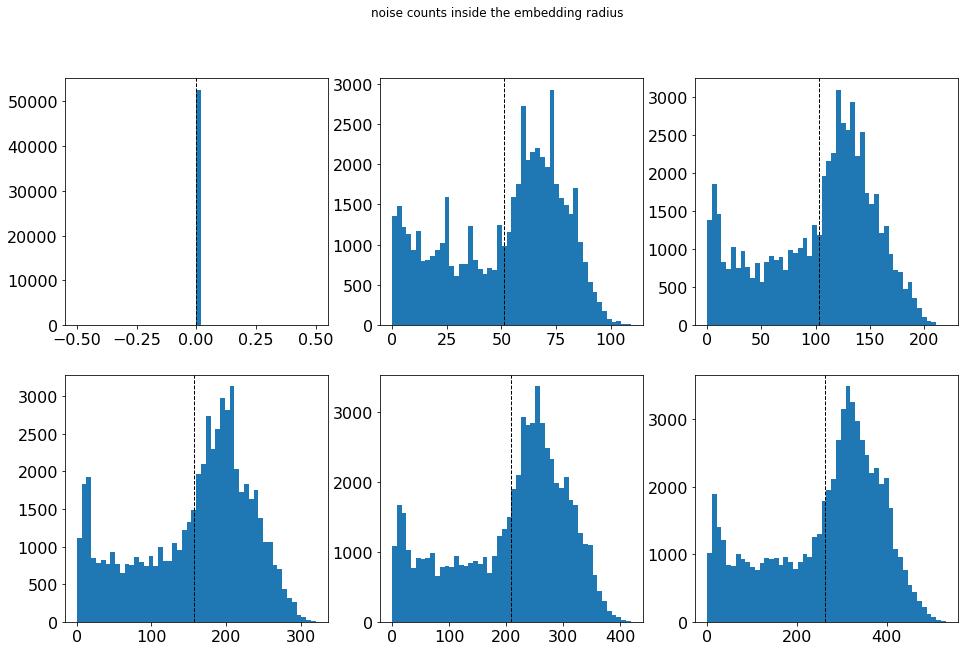

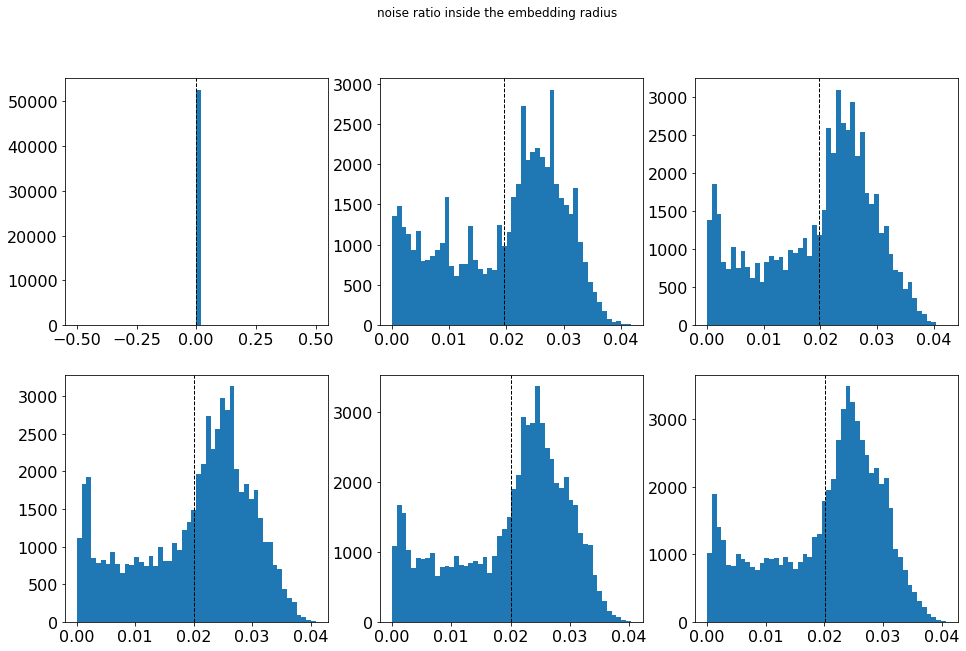

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
noise_counts = []
noise_ratios = []
total_ratios = []

fig1, axes1 = plt.subplots(2, 3, figsize=(16,10))
fig2, axes2 = plt.subplots(2, 3, figsize=(16,10))

fig1.suptitle("noise counts inside the embedding radius")
fig2.suptitle("noise ratio inside the embedding radius")

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    total_noise = sum(truth['particle_id']==0)
    truth_np = np.array(truth.values)
    ncounts = []
    nratios = []
    tratios = []
    for j in tqdm(range(len(neighbors))):
        n_noise = 0
        for k in neighbors[j]:
            if truth_np[k, 1] == 0: n_noise+=1
        ncounts.append(n_noise)
        nratios.append(n_noise / total_noise if total_noise > 0 else 0)
        tratios.append(len(neighbors[j])/len(hits))
    noise_count = sum(ncounts)/len(ncounts)
    noise_ratio = sum(nratios)/len(nratios)
    total_ratio = sum(tratios)/len(tratios)
    print("result:", noise_count, noise_ratio, total_ratio)
    noise_counts.append(noise_count)
    noise_ratios.append(noise_ratio)
    total_ratios.append(total_ratio)
    
    axes1[i//3][i%3].hist(ncounts, 50)
    axes1[i//3][i%3].axvline(noise_count, color='k', linestyle='dashed', linewidth=1)
    axes2[i//3][i%3].hist(nratios, 50)
    axes2[i//3][i%3].axvline(noise_ratio, color='k', linestyle='dashed', linewidth=1)

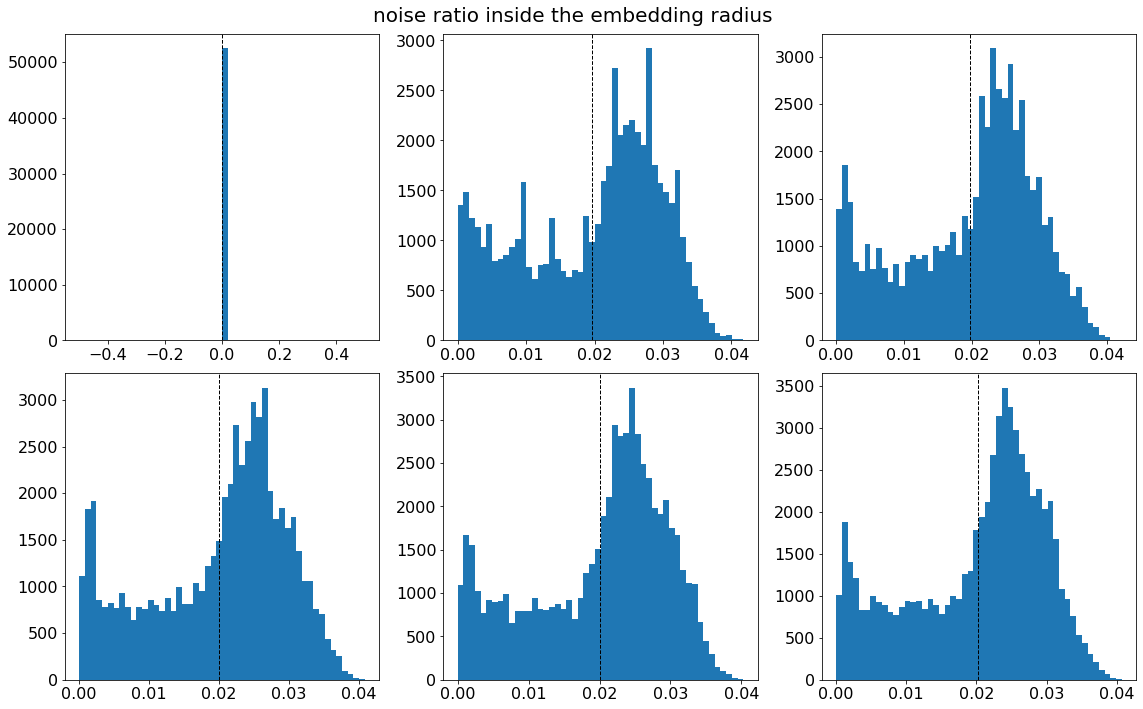

In [21]:
fig2.suptitle("noise ratio inside the embedding radius", fontsize=20)
fig2.tight_layout()
fig2

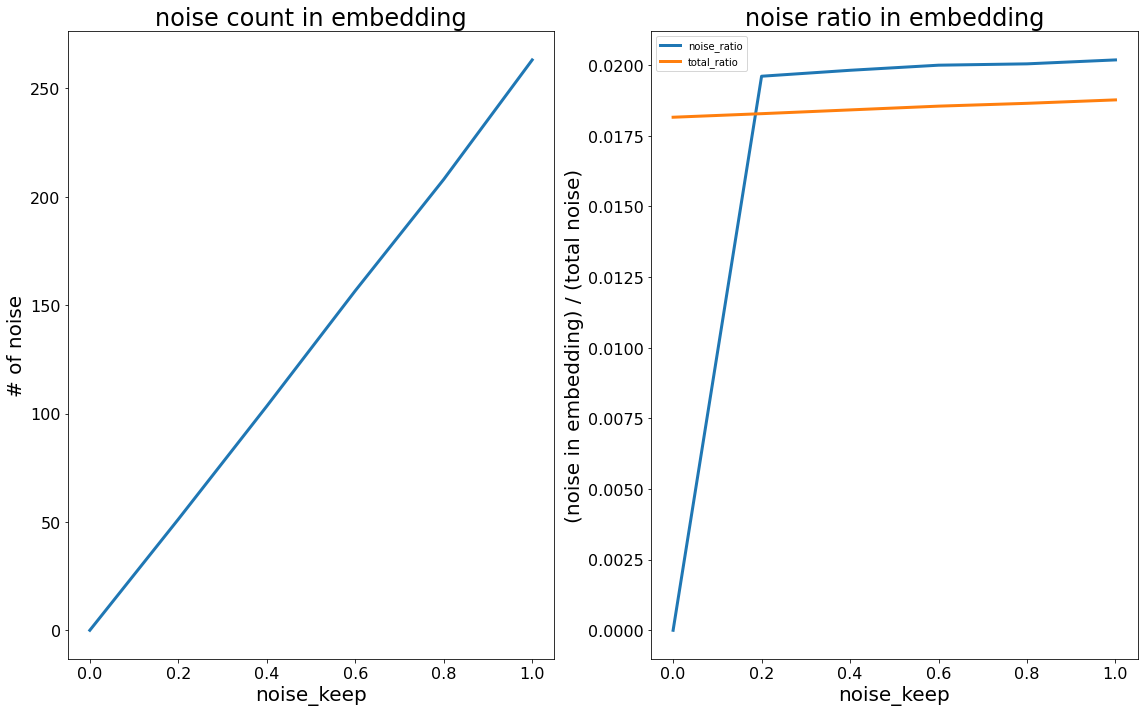

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, noise_counts)
ax1.set_title("noise count in embedding")
ax1.set_xlabel("noise_keep")
ax1.set_ylabel("# of noise")
ax2.plot(x, noise_ratios, label='noise_ratio')
ax2.plot(x, total_ratios, label='total_ratio')
ax2.set_title("noise ratio in embedding")
ax2.set_xlabel("noise_keep")
ax2.set_ylabel("(noise in embedding) / (total noise)")
ax2.legend()

plt.tight_layout()

In [23]:
import seaborn as sns

# Noise count/ ratio for filtering

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
noise_counts = []
noise_ratios = []
total_ratios = []

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    
    # get all pairs that hae noise in it
    def get_n_noise_pairs(pairs):
        truth_np = np.array(truth.values)
        n = 0
        for pair in tqdm(pairs):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a == 0 or hit_b == 0: # if either hit is noise
                n += 1
        return n
                
    n_filter_noise_pairs = get_n_noise_pairs(filter_pairs)
    n_total_noise_pairs = get_n_noise_pairs(idx_pairs)
    
    noise_ratio = n_filter_noise_pairs / n_total_noise_pairs if n_total_noise_pairs > 0 else 0
    total_ratio = len(filter_pairs) / len(idx_pairs)
    print("result:", n_filter_noise_pairs, noise_ratio, total_ratio)
    noise_counts.append(n_total_noise_pairs)
    noise_ratios.append(noise_ratio)
    total_ratios.append(total_ratio)

event: 0 number of hits: 52482
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 10659558/10659558 [00:23<00:00, 447104.05it/s]


result: 0 0 0.11107768258308647
event: 0.2 number of hits: 55094
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 11653832/11653832 [00:25<00:00, 451108.58it/s]


result: 99061 0.0996228730037411 0.11010112381918669
event: 0.4 number of hits: 57699
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 12768900/12768900 [00:29<00:00, 438570.74it/s]


result: 208079 0.0986371904003671 0.10902411327522339
event: 0.6 number of hits: 60314
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 13959788/13959788 [00:32<00:00, 435419.81it/s]


result: 327160 0.09912539623192604 0.10825372133158469
event: 0.8 number of hits: 62859
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 15197721/15197721 [00:33<00:00, 455949.12it/s]


result: 452242 0.09964771787816344 0.10766620863746611
event: 1 number of hits: 65518
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 16585200/16585200 [00:37<00:00, 446354.10it/s]

result: 596138 0.10059843902639878 0.10733527482333646


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, noise_counts)
ax1.ticklabel_format(style='plain')
ax1.set_title("noise count for filtering")
ax1.set_xlabel("noise_keep")
ax1.set_ylabel("# of noise pairs")
ax2.plot(x, noise_ratios, label='noise_ratio')
#ax2.plot(x, total_ratios, label='total_ratio')
ax2.set_title("noise ratio for filtering")
ax2.set_xlabel("noise_keep")
ax2.set_ylabel("(noise pairs in filtering) / (total noise pairs)")
ax2.legend()

plt.tight_layout()

In [11]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_1/preprocess_raw"
hits, truth = load_event(data_path, event_name)
print("event:", noise_keep, "number of hits:", len(hits))

neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)

total_noise = sum(truth['particle_id']==0)
truth_np = np.array(truth.values)
noise_counts = []
noise_ratio = []
for j in tqdm(range(len(neighbors))):
    n_noise = 0
    for k in neighbors[j]:
        if truth_np[k, 1] == 0: n_noise+=1
    noise_counts.append(n_noise)
    noise_ratio.append(n_noise / total_noise if total_noise > 0 else 0)
count = sum(noise_counts)/len(noise_counts)
ratio = sum(noise_ratio)/len(noise_ratio)
print("result:", count, ratio)

event: 1 number of hits: 65518


100%|██████████| 65518/65518 [00:53<00:00, 1230.23it/s]

result: 263.13065111877654 0.020184922608067795


In [27]:
len(hits)

65518

In [12]:
import pandas as pd
import seaborn as sns

df_count = pd.DataFrame(list(zip(hits['volume_id'], hits['layer_id'], noise_counts)), columns = ['volume_id', 'layer_id', 'noise_counts'])

<AxesSubplot:xlabel='volume_id', ylabel='layer_id'>

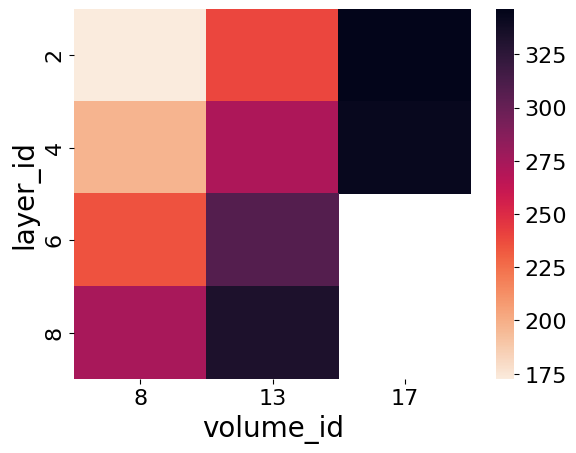

In [13]:
pv_count = df_count.pivot_table(values='noise_counts',index='layer_id',columns='volume_id')
sns.heatmap(pv_count, cmap = sns.cm.rocket_r)

<AxesSubplot:xlabel='volume_id', ylabel='layer_id'>

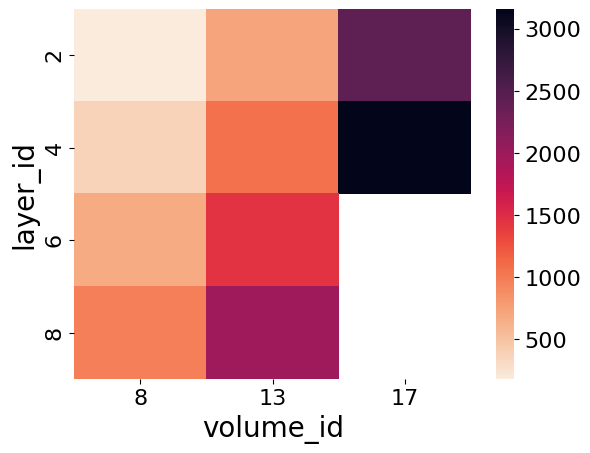

In [14]:
noise_hits = hits[truth['particle_id']==0]
df_count = pd.DataFrame(list(zip(noise_hits['volume_id'], noise_hits['layer_id'], np.ones(len(noise_hits)))), columns = ['volume_id', 'layer_id', 'noise_counts'])
pv_count = df_count.pivot_table(values='noise_counts',index='layer_id',columns='volume_id', aggfunc=np.sum)
sns.heatmap(pv_count, cmap = sns.cm.rocket_r)

In [15]:
import pandas as pd
import seaborn as sns

def round_series(series, n_split):
    width = (series.max() - series.min()) / n_split
    return np.round((series - series.min()) / width) * width + series.min()


In [41]:
def heat_map_with_round(hits, values, x, y, n_split, aggfunc=np.mean, label='noise_counts'):
    df = pd.DataFrame(list(zip(hits[x], hits[y], values)), columns = [x, y, label])
    df[x] = round_series(df[x], n_split)
    df[y] = round_series(df[y], n_split)

    pv_count = df.pivot_table(values=label,index=y, columns=x, aggfunc=aggfunc)
    sns.heatmap(pv_count, xticklabels=False, yticklabels=False, cmap = sns.cm.rocket_r)
    #sns.heatmap(pv_count, xticklabels=False, yticklabels=False, cmap = "PiYG")

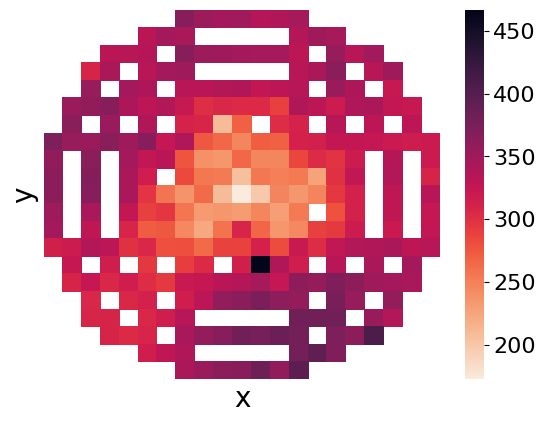

In [17]:
heat_map_with_round(hits, noise_counts, 'x', 'y', 20)

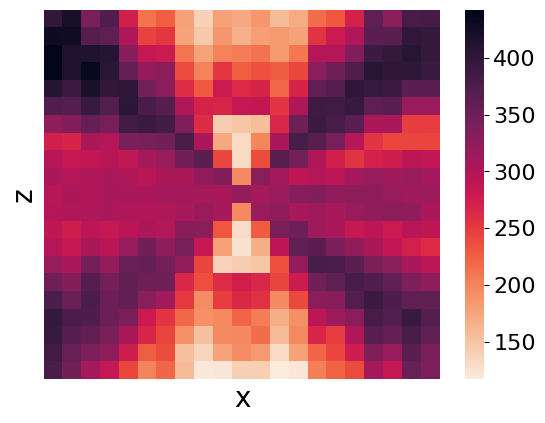

In [18]:
heat_map_with_round(hits, noise_counts, 'x', 'z', 20)

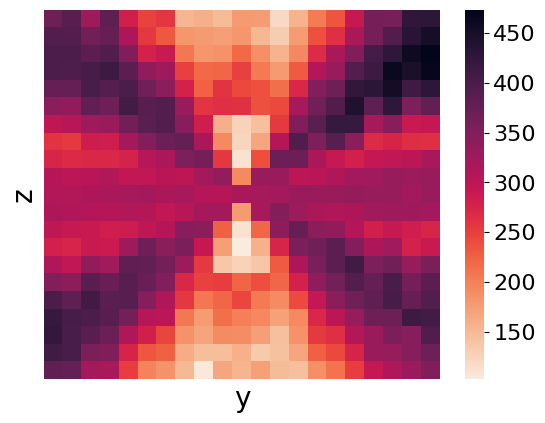

In [19]:
heat_map_with_round(hits, noise_counts, 'y', 'z', 20)

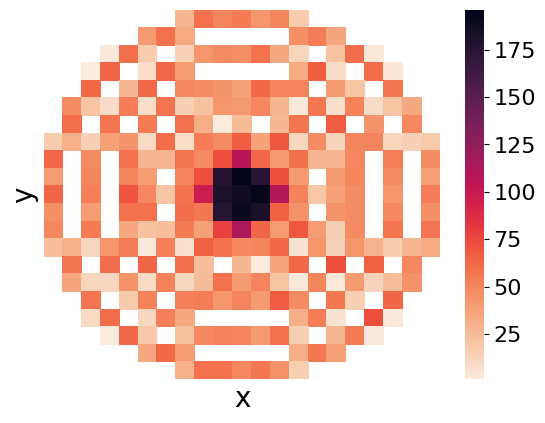

In [20]:
noise_hits = hits[truth['particle_id']==0]
heat_map_with_round(noise_hits, np.ones(len(noise_hits)), 'x', 'y', 20, aggfunc=np.sum)

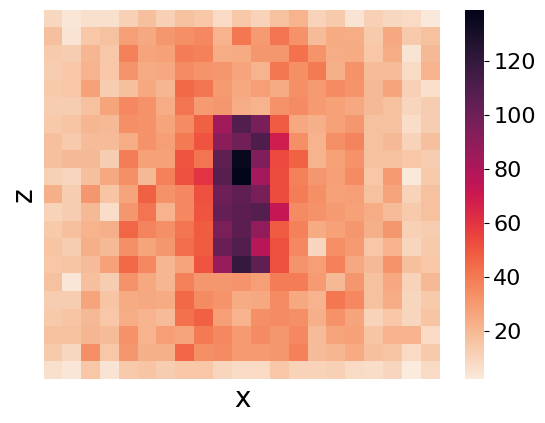

In [21]:
noise_hits = hits[truth['particle_id']==0]
heat_map_with_round(noise_hits, np.ones(len(noise_hits)), 'x', 'z', 20, aggfunc=np.sum)

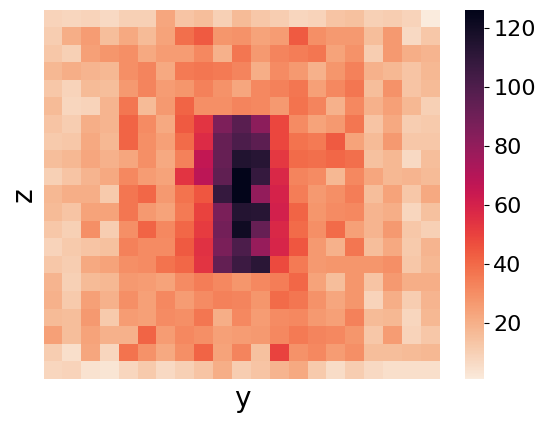

In [22]:
noise_hits = hits[truth['particle_id']==0]
heat_map_with_round(noise_hits, np.ones(len(noise_hits)), 'y', 'z', 20, aggfunc=np.sum)

In [30]:
from MetricLearning.src.preprocess_with_dir.extract_dir import cartesion_to_spherical, theta_to_eta
hits['r'], theta, hits['phi'] = cartesion_to_spherical(hits['x'], hits['y'], hits['z'])
hits['eta'] = theta_to_eta(theta)

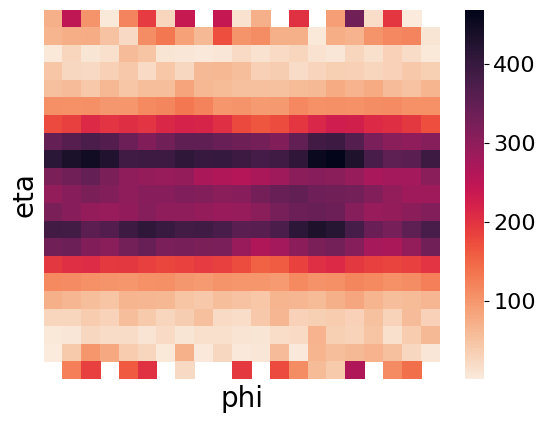

In [24]:
heat_map_with_round(hits, noise_counts, 'phi', 'eta', 20)

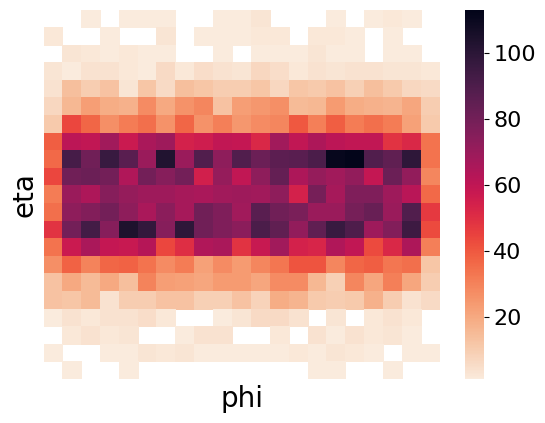

In [25]:
noise_hits = hits[truth['particle_id']==0]
heat_map_with_round(noise_hits, np.ones(len(noise_hits)), 'phi', 'eta', 20, aggfunc=np.sum)

# Get noise count for trained without noise

In [26]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

In [27]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_1/preprocess_raw"
hits, truth = load_event(data_path, event_name)
print("event:", noise_keep, "number of hits:", len(hits))

neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)

total_noise = sum(truth['particle_id']==0)
truth_np = np.array(truth.values)
noise_counts2 = []
noise_ratio2 = []
for j in tqdm(range(len(neighbors))):
    n_noise = 0
    for k in neighbors[j]:
        if truth_np[k, 1] == 0: n_noise+=1
    noise_counts2.append(n_noise)
    noise_ratio2.append(n_noise / total_noise if total_noise > 0 else 0)
count = sum(noise_counts2)/len(noise_counts2)
ratio = sum(noise_ratio2)/len(noise_ratio2)
print("result:", count, ratio)

event: 1 number of hits: 65518


100%|██████████| 65518/65518 [00:52<00:00, 1241.38it/s]

result: 261.0071888641289 0.020022030443703754


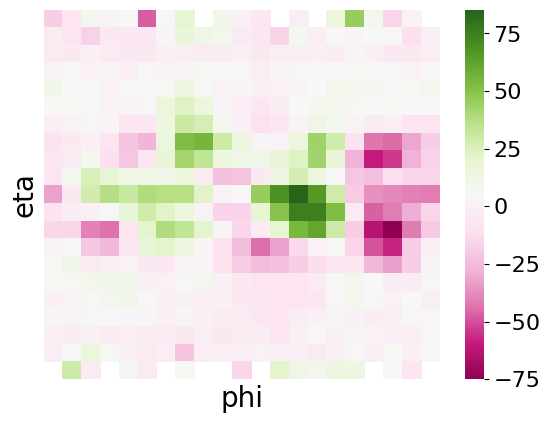

In [42]:
heat_map_with_round(hits, [noise_counts[i] - noise_counts2[i] for i in range(len(noise_counts))], 'phi', 'eta', 20)

# get filtering efficiency of 0.9622583833464098

In [54]:
def get_filter_eff_purity_with_threshold(hits, truth, idx_pairs, scores, true_pairs, threshold):
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, threshold)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [47]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_with_noise"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

In [51]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_0/preprocess_raw"
hits, truth = load_event(data_path, event_name)
    
neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)

vol = hits[['volume_id', 'layer_id']].values.T

batch_size = 64
num_workers = 12 if DEVICE=='cuda' else 0
dataset = EdgeData(hits[feature_names].values, vol, neighbors)
loader = DataLoader(dataset,
                    batch_size = batch_size,
                    num_workers = num_workers,
                    collate_fn = my_collate)
# apply filter model
idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)

# get true pairs
true_pairs = []
truth_np = np.array(truth.values)

with torch.autograd.no_grad():
    for i, pair in tqdm(enumerate(idx_pairs)):
        hit_a = truth_np[pair[0], 1]
        hit_b = truth_np[pair[1], 1]
        if hit_a != 0 and hit_a == hit_b: #compare particle id
            true_pairs.append((pair[0], pair[1]))

    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered


0it [00:00, ?it/s]

  100% of doublets filtered


10659558it [00:20, 508833.04it/s]


In [61]:
lower = 0.0
higher = 1.0
for i in tqdm(range(100)):
    mid = (lower + higher) / 2
    purity, efficiency = get_filter_eff_purity_with_threshold(hits, truth, idx_pairs, scores, true_pairs, mid)
    if efficiency > 0.9622583833464098:
        lower = mid
    else:
        higher = mid
mid

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


0.9613757431507111

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
filter_ps = []
filter_efs = []

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, neighbors, threshold=0.9613757431507111)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
plt.tight_layout()

event: 0 number of hits: 52482
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered


0it [00:00, ?it/s]

  100% of doublets filtered


10659558it [00:19, 558309.80it/s]


filter result: 0.08588945332652732 0.9622618428698125
event: 0.2 number of hits: 55094
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


11653832it [00:21, 548859.79it/s]


filter result: 0.0793570727795026 0.9622618428698125
event: 0.4 number of hits: 57699
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


12768900it [00:23, 543361.59it/s]


filter result: 0.07323720957658271 0.9622422246913832
event: 0.6 number of hits: 60314
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


13959788it [00:25, 546646.74it/s]


filter result: 0.06754759889198896 0.9622422246913832
event: 0.8 number of hits: 62859
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


15197721it [00:26, 563659.93it/s]


filter result: 0.062439475480624215 0.9622716522590116
event: 1 number of hits: 65518
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


16585200it [00:28, 584485.50it/s]


filter result: 0.05744398458423627 0.9622520336806051


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'noise_level')

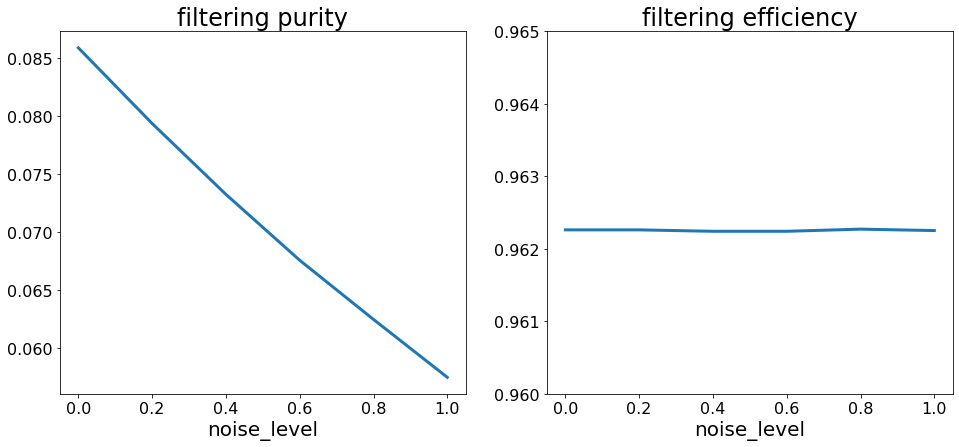

In [72]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,20/3))
x = [float(keep) for keep in noise_keeps]

ax1.plot(x, filter_ps)
ax1.set_title("filtering purity")
ax1.set_xlabel("noise_level")
ax2.plot(x, filter_efs)
ax2.set_ylim(0.96, 0.965)
ax2.set_title("filtering efficiency")
ax2.set_xlabel("noise_level")